### Imports and configuration

#### Imports

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import random
from collections import defaultdict
from tqdm.notebook import trange, tqdm

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


#### Paths

In [2]:
# Where are we going to work?
data_path = '../data/gen4/'
work_path = '../data/work/'
pickle_path = os.path.join(work_path, 'out.pickle')
checkpoint_path = os.path.join(work_path, 'checkpoint_{epoch:02d}.h5')

#### Parameters

In [3]:
# Random
seed = 1337
np.random.seed(seed)
random.seed(seed)

# Force data preparation
force_conversion = True

# Only use a few examples
subsamples = True
subsamples_num = 10

### Data preparation/retrieving

In [4]:
if not os.path.exists(pickle_path) or force_conversion:  # If we need to convert data
    # Collect files
    names = []
    for root, dirs, files in os.walk(data_path):
        for name in files:
            names.append(os.path.join(root, name.split('.')[0]))
    names = list(set(names))  # We only want the files once - discard .jpg/.xml duality
    
    # Columns
    columns = ['file_name', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']

    # Data
    data = []
    for name in names:
        xml_path = name + '.xml'
        try:
            tree = ET.parse(xml_path)
        except:  # The annotation file is missing.
            continue
        root = tree.getroot()

        for obj in root.findall('object'):
            temp = [name + '.jpg', obj.find('name').text]
            for child in obj.find('bndbox'):
                temp.append(child.text)
            data.append(temp)
        
        if subsamples:
            if subsamples_num > 0:
                subsamples_num -= 1
            else:
                break

    # Create a new pandas dataframe
    df = pd.DataFrame(data, columns=columns)
    df.head()
    
    # Save pickle
    df.to_pickle(pickle_path)
else:  # The data is already available
    df = pd.read_pickle(pickle_path)

In [5]:
# See the df
df.head()

,file_name,class_name,xmin,ymin,xmax,ymax
0,../data/gen4/gen4_096/gen4_096_174.jpg,publicite,1,1,480,638
1,../data/gen4/gen4_096/gen4_096_174.jpg,pub_pleine_page,1,1,480,639
2,../data/gen4/gen4_096/gen4_096_174.jpg,pub_texte,1,2,480,639
3,../data/gen4/gen4_096/gen4_096_174.jpg,pub_services,1,1,480,638
4,../data/gen4/gen4_096/gen4_096_174.jpg,logo,5,598,80,640


In [6]:
# See files
files = df.groupby('file_name').size().reset_index(name='counts')
files

,file_name,counts
0,../data/gen4/gen4_013/gen4_013_149.jpg,3
1,../data/gen4/gen4_013/gen4_013_150.jpg,3
2,../data/gen4/gen4_038/gen4_038_096.jpg,3
3,../data/gen4/gen4_038/gen4_038_188.jpg,7
4,../data/gen4/gen4_072/gen4_072_108.jpg,4
5,../data/gen4/gen4_089/gen4_089_023.jpg,3
6,../data/gen4/gen4_096/gen4_096_021.jpg,2
7,../data/gen4/gen4_096/gen4_096_022.jpg,2
8,../data/gen4/gen4_096/gen4_096_174.jpg,6
9,../data/gen4/gen4_109/gen4_109_040.jpg,3


In [7]:
# See classes
classes = df.groupby('class_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
classes

,class_name,counts
1,contenu_editorial,8
0,article,6
2,logo,3
9,pub_pleine_page,3
13,publicite,3
3,message,2
4,news,2
6,pub_double,2
7,pub_image,2
11,pub_services,2


In [8]:
# See numbers
# Why use len(foo.index)? https://stackoverflow.com/a/15943975
num_classes = len(classes.index)
num_files = len(files.index)
num_pod = len(df.index)
print("We have {} classes in {} files for {} points of data.".format(num_classes, num_files, num_pod))

We have 16 classes in 11 files for 41 points of data.


#### Example

In [9]:
sample_row = files.sample(1, random_state=seed)
sample_file = sample_row.iloc[0, 0]
sample_data = df.loc[df['file_name'] == sample_file]
sample_data

,file_name,class_name,xmin,ymin,xmax,ymax
17,../data/gen4/gen4_072/gen4_072_108.jpg,contenu_editorial,1,1,480,639
18,../data/gen4/gen4_072/gen4_072_108.jpg,article,1,1,480,639
19,../data/gen4/gen4_072/gen4_072_108.jpg,test,2,1,480,639
20,../data/gen4/gen4_072/gen4_072_108.jpg,note,357,184,462,488


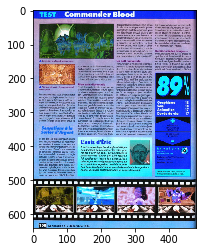

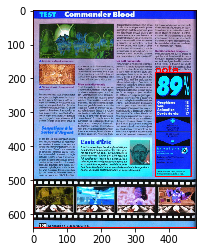

In [10]:
img = cv2.imread(sample_file)
plt.imshow(img)
for index, row in sample_data.iterrows():
    class_name, xmin, ymin, xmax, ymax = row['class_name'], int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.putText(img, class_name, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA) 
plt.figure()
plt.imshow(img)

### Recognition and data expension

In [11]:
cv2.setUseOptimized(True)  # Enables the optimized code.

#### Example

Processing Selective Search...


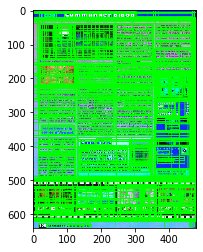

In [12]:
# We are using selective search to find potential areas of interest.
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()  # Uses optimized selective search (https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/)
img = cv2.imread(sample_file)
ss.setBaseImage(img)
print("Processing Selective Search...")
ss.switchToSelectiveSearchFast()
rects = ss.process()
img_out = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(img_out)

#### All

In [13]:
train_images = []
train_labels = []

In [14]:
# Uses optimized selective search (https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [15]:
def get_iou(bb1, bb2):  # Intersection over Union (IoU) (https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
    # Basically, Area of Intersection / Area of Union...
    # bb1, bb2: {xmin, ymin, xmax, ymax}
    assert bb1['xmin'] < bb1['xmax']
    assert bb1['ymin'] < bb1['ymax']
    assert bb2['xmin'] < bb2['xmax']
    assert bb2['ymin'] < bb2['ymax']

    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['xmax'] - bb1['xmin']) * (bb1['ymax'] - bb1['ymin'])
    bb2_area = (bb2['xmax'] - bb2['xmin']) * (bb2['ymax'] - bb2['ymin'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
# Parameters
N = 2000
IOU_THRESHOLD = 0.8
MAX_SAMPLES = 30  # We need to balance the numbers of examples for each class

In [17]:
# Loop over each image
for index, row in tqdm(files.iterrows(), total=num_files, desc="Iterating through files..."):
    file = row[0]
    data = df.loc[df['file_name'] == file]
    img = cv2.imread(file)
    
    # Set image as the base for selective search
    ss.setBaseImage(img)
    
    # Initialising fast selective search and getting proposed regions
    print("Processing Selective Search...")
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    img_out = img.copy()
    
    classes_counter = defaultdict(int)  # As stated, we need an uniform sample between classes
    
    # Iterate over the first N results of selective search
    # Calculate IOU of proposed region and annoted region
    used = False  # Check if that bbox is used as a class example
    
    # For each rectangle in the results of selective search
    for i, rect in enumerate(tqdm(rects, desc="Iterating through rectangles...", leave=False)):
        if i < N:  # We don't want to waste ressources on too many possibilities.
            x, y, w, h = rect
            rect_bbox = {'xmin': x, 'xmax': x + w, 'ymin': y, 'ymax': y + h}
            
            # For each bbox within the image
            for index, row in data.iterrows():
                ground_truth_bbox = {'xmin': int(row['xmin']), 'xmax': int(row['xmax']),
                                     'ymin': int(row['ymin']), 'ymax': int(row['ymax'])}
                ground_truth_class_name = row['class_name']
                
                # Compare them
                iou = get_iou(ground_truth_bbox, rect_bbox)
                
                if iou > IOU_THRESHOLD and classes_counter[ground_truth_class_name] < MAX_SAMPLES:
                    img_sample = cv2.resize(img_out[y:y + h, x:x + w], (224,224), interpolation = cv2.INTER_AREA)  # Get the sample
                    train_images.append(img_sample)
                    train_labels.append(ground_truth_class_name)
                    classes_counter[ground_truth_class_name] += 1
                    used = True
                else:
                    continue
                    
            if not used and classes_counter['background'] < MAX_SAMPLES: # We can use that bbox as a background example!
                img_sample = cv2.resize(img_out[y:y + h, x:x + w], (224, 224), interpolation = cv2.INTER_AREA)  # Get the sample
                train_images.append(img_sample)
                train_labels.append('background')  # Background
                classes_counter['background'] += 1
        else:
            break

Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


Processing Selective Search...


In [18]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

### Model
We are going to use transfer learning, aka "We do not have time to train a whole new model for a while so let's cut through an existing model and specialize it". https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9.

In [19]:
# Import pretrained original VGG16 model with ImageNet weights
vggmodel = VGG16(weights='imagenet', include_top=True)  # https://keras.io/applications/
vggmodel.summary()  # Pretty sure I can optimize that thing...











_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         


In [20]:
# Freeze first 15 layers
for i, layers in enumerate(vggmodel.layers[:15]):
    layers.trainable = False
    print("- Layer {} ({}) is not trainable anymore.".format(layers.get_config()['name'], i + 1))

- Layer input_1 (1) is not trainable anymore.
- Layer block1_conv1 (2) is not trainable anymore.
- Layer block1_conv2 (3) is not trainable anymore.
- Layer block1_pool (4) is not trainable anymore.
- Layer block2_conv1 (5) is not trainable anymore.
- Layer block2_conv2 (6) is not trainable anymore.
- Layer block2_pool (7) is not trainable anymore.
- Layer block3_conv1 (8) is not trainable anymore.
- Layer block3_conv2 (9) is not trainable anymore.
- Layer block3_conv3 (10) is not trainable anymore.
- Layer block3_pool (11) is not trainable anymore.
- Layer block4_conv1 (12) is not trainable anymore.
- Layer block4_conv2 (13) is not trainable anymore.
- Layer block4_conv3 (14) is not trainable anymore.
- Layer block4_pool (15) is not trainable anymore.


In [50]:
# Add a {number of classes} unit softmax dense layer
predictions = Dense(len(set(train_labels)), activation="softmax")(vggmodel.layers[-2].output)  # Maybe not all labels
model = Model(input = vggmodel.input, output = predictions)

/home/stache/miniconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
# Compile the model using Adam optimizer with learning rate of 0.001
# We are using categorical_crossentropy as loss since the output of the model is categorical
opt = Adam(lr=0.0001)
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [85]:
# One-hot encoding: Basically "unique-fy-ish" each class.
# https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
# from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
        
lenc = MyLabelBinarizer()

In [86]:
mlb = MultiLabelBinarizer()

In [89]:
chosen_binarizer = lenc
train_labels_fit = chosen_binarizer.fit_transform(train_labels)
# train_labels_fit = chosen_binarizer.fit_transform([train_labels])  # For mlb
chosen_binarizer.classes_

array(['article', 'background', 'contenu_editorial', 'logo', 'message',
       'news', 'note', 'pub_double', 'pub_image', 'pub_materiel_info',
       'pub_pleine_page', 'pub_produits_mag', 'pub_services', 'pub_texte',
       'publicite', 'soluce'], dtype='<U17')

In [90]:
# Test and train set, yay.
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_fit, test_size=0.10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(346, 224, 224, 3) (39, 224, 224, 3) (346, 16) (39, 16)


In [91]:
# Dataset augmentation
# This may not be needed following some magazines, as we do not often have rotated texts...
# ... Or do we? Anyway it applies for the pictures so there's that.
imgdatagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_data = imgdatagen.flow(x=X_train, y=y_train)
imgdatagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_data = imgdatagen.flow(x=X_test, y=y_test)

In [92]:
# We want checkpoints because losing training suckz lolz. https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)

# If we are not doing any progress, stops the whole thing. https://keras.io/callbacks/#earlystopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [93]:
# FINALLY train the model. https://keras.io/models/sequential/#fit_generator
hist = model.fit_generator(generator=train_data, steps_per_epoch=10, epochs=2, verbose=1, validation_data=test_data,
                           validation_steps=2, callbacks=[checkpoint, early])

Epoch 1/2
10/10 [==============================] - 118s 12s/step - loss: 0.4567 - acc: 0.8344 - val_loss: 0.7288 - val_acc: 0.7179

Epoch 00001: val_loss improved from inf to 0.72881, saving model to ../data/work/checkpoint_01.h5
Epoch 2/2
10/10 [==============================] - 115s 12s/step - loss: 0.5201 - acc: 0.8315 - val_loss: 0.7598 - val_acc: 0.6923

Epoch 00002: val_loss did not improve from 0.72881


### Moment of (ground) truth

#### Visualization

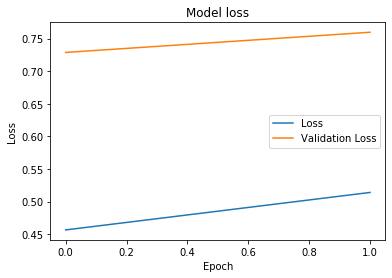

In [94]:
# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.show()

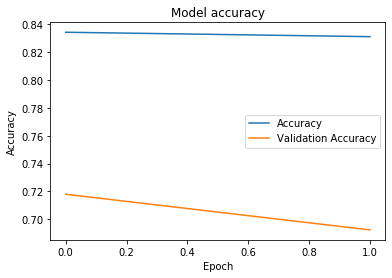

In [95]:
# Accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

#### Testing

Guess: contenu_editorial with probability 0.34324538707733154.


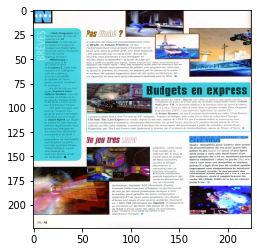

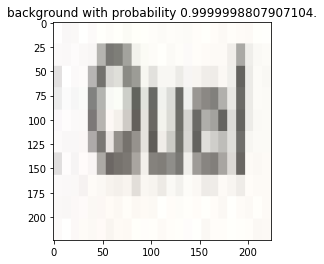

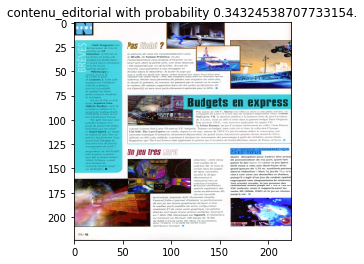

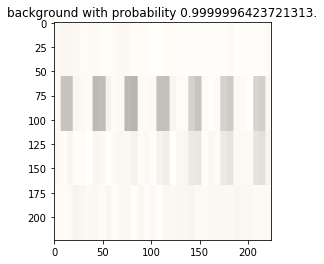

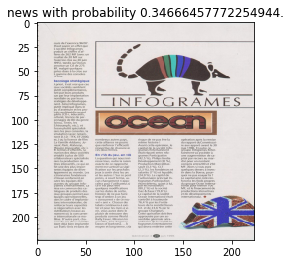

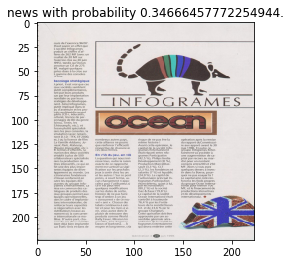

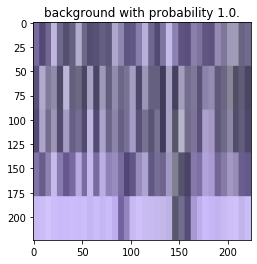

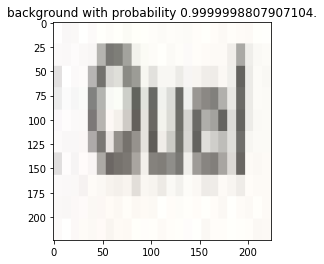

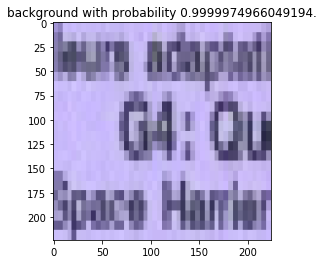

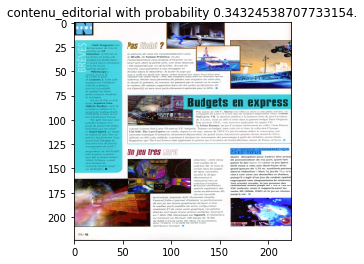

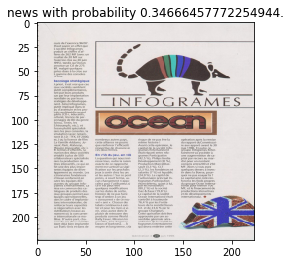

In [104]:
for i in range(10):
    test_img = X_test[random.randint(0, num_files)]
    plt.figure()
    test_out = np.expand_dims(test_img, axis=0)
    test_out = model.predict(test_out)
    guess = chosen_binarizer.classes_[test_out.argmax()]
    guess_probability = test_out.max()
    plt.title("{} with probability {}.".format(guess, guess_probability))
    plt.imshow(test_img)